In [0]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import xlogy
import scipy.io
import h5py

from sklearn.metrics import accuracy_score

In [0]:
def relu(Z):

  """Applies relu function to an array/value

    Arguments
    ---------
    Z: float/int/array_like
      Original Value

    Returns
    -------
    A: same shape as input
      Value after applying relu function
  """
  
  return np.maximum(Z, 0)

In [0]:
def relu_prime(Z):
  
  """Applies differentiation of relu function to an array/value

    Arguments
    ---------
    Z: float/int/array_like
      Original Value

    Returns
    -------
    A: same shape as input
      Value after applying diff of relu function
  """

  return (Z>0).astype(Z.dtype)

In [0]:
def sigmoid(Z):

  """Applies sigmoid function to an array/value

    Arguments
    ---------
    Z: float/int/array_like
      Original Value

    Returns
    -------
    A: same shape as input
      Value after applying sigmoid function
  """    
  
  return 1/(1+np.power(np.e, -Z))

In [0]:
def sigmoid_prime(Z):

  """Applies differentiation of sigmoid function to an array/value

    Arguments
    ---------
    Z: float/int/array_like
      Original Value

    Returns
    -------
    A: same shape as input
      Value after applying diff of sigmoid function
  """
  
  return Z * (1-Z)

In [0]:
def leaky_relu(Z, alpha=0.01):

  """Applies leaky relu function to an array/value

    Arguments
    ---------
    Z: float/int/array_like
      Original Value
    alpha: float
      Negative slope coefficient

    Returns
    -------
    A: same shape as input
      Value after applying leaky relu function
  """   

  return np.where(Z > 0, Z, Z * alpha)

In [0]:
def leaky_relu_prime(Z, alpha=0.01):

  """Applies differentiation of leaky relu function to an array/value

    Arguments
    ---------
    Z: float/int/array_like
      Original Value
    alpha: float
      Negative slope coefficient

    Returns
    -------
    A: same shape as input
      Value after applying diff of leaky relu function
  """

  dz = np.ones_like(Z)
  dz[Z < 0] = alpha
  return dz

In [0]:
def tanh(Z):

  """Applies tanh function to an array/value

    Arguments
    ---------
    Z: float/int/array_like
      Original Value

    Returns
    -------
    A: same shape as input
      Value after applying tanh function
  """   

  return np.tanh(Z)

In [0]:
def tanh_prime(Z):
  
  """Applies differentiation of tanh function to an array/value

    Arguments
    ---------
    Z: float/int/array_like
      Original Value

    Returns
    -------
    A: same shape as input
      Value after applying diff of tanh function
  """

  return 1-(tanh(Z)**2)

In [0]:
def get_activation_function(name):

  """Returns function corresponding to an activation name

    Arguments
    ---------
    name: string
      'relu', 'leaky_relu', 'tanh' or 'sigmoid' activation

    Returns
    -------
    Corresponding activation function
  """

  if name=='relu':
    return relu
  elif name=='sigmoid':
    return sigmoid
  elif name=='leaky_relu':
    return leaky_relu
  elif name=='tanh':
    return tanh
  else:
    raise ValueError('Only "relu", "leaky_relu", "tanh" and "sigmoid" supported')

In [0]:
def get_derivative_activation_function(name):

  """Returns differentiation function corresponding to an activation name

  Arguments
  ---------
  name: string
    'relu', 'leaky_relu', 'tanh' or 'sigmoid' activation

  Returns
  -------
  Corresponding diff of activation function
  """

  if name=='relu':
    return relu_prime
  elif name=='sigmoid':
    return sigmoid_prime
  elif name=='leaky_relu':
    return leaky_relu_prime
  elif name=='tanh':
    return tanh_prime
  else:
    raise ValueError('Only "relu", "leaky_relu", "tanh" and "sigmoid" supported')

In [0]:
def initialize_layer_weights(n_l_1, n_l, random_state=0):

  """Initializes random weights and bias for a layer l

    Arguments
    ---------
    n_l_1: int
      Number of neurons in previous layer (l-1)
    n_l_1: int
      Number of neurons in current layer (l)
    random_state: int
      Random seed

    Returns
    -------
    dict
      Contains the randomly initialized weights and bias arrays

      The keys for weights and bias arrays in the dict are 'W1', 'b1', 'W2' and 'b2'
  """

  np.random.seed(random_state)

  wl = np.random.randn(n_l_1, n_l) / np.sqrt(n_l_1)
  bl = np.random.randn(1, n_l)

  return {'wl': wl, 'bl': bl}

In [0]:
class Dense:
  
  """Returns a dense layer with randomly initialized weights and bias

    Arguments
    ---------
    input_dim: int
      Number of neurons in previous layer.
    units: int
      Number of neurons in the layer.
    activation: str
      Activation function to use. 'relu', 'leaky_relu', 'tanh' or 'sigmoid'
    random_state: int
      Random seed

    Returns
    -------
    Dense layer
      An instance of the Dense layer initialized with random params.
  """

  def __init__(self, input_dim, units, activation, random_state=0):

    params = initialize_layer_weights(input_dim, units, random_state)

    self.units = units
    self.W = params['wl']
    self.b = params['bl']
    self.activation = activation
    self.Z = None
    self.A = None
    self.dz = None
    self.da = None
    self.dw = None
    self.db = None

In [0]:
def forward_prop(X, model):
  
  """Performs forward propagation and calculates output value

    Arguments
    ---------
    X: array_like
      Data
    model: list
      List containing the layers

    Returns
    -------
    Model: list
      List containing layers with updated 'Z' and 'A'
  """

  for i in range(len(model)):

    if i==0:
      X_l_1 = X.copy()
    else:
      X_l_1 = model[i-1].A

    model[i].Z = np.dot(X_l_1, model[i].W) + model[i].b
    model[i].A = get_activation_function(model[i].activation)(model[i].Z)
    
  return model

In [0]:
def calculate_loss(y, model, l2_lambda=0):

  """Calculate the L2 regularization loss

    Arguments
    --------- 
    y: array-like
      True lables
    model: list
      List containing the layers
    l2_lambda: float
      Lambda to use in L2 regularization

    Returns
    -------
    loss: float
      Entropy loss
  """

  m = y.shape[0]
  A = model[-1].A

  cross_entropy_loss = np.squeeze(-(1./m)*np.nansum(np.multiply(y, np.log(A+1e-15))+np.multiply(np.log(1-A+1e-15), 1-y)))
  regularization_cost = (l2_lambda/(2.*m)) * np.sum([np.sum(np.square(l.W)) for l in model])

  return cross_entropy_loss +  regularization_cost

In [0]:
def backward_prop(X, y, model):

  """Performs backward propagation

    Arguments
    ---------
    X: array_like
      Data
    y: array_like
      True labels
    model: list
      List containing the layers

    Returns
    -------
    model: list
      List containing the layers with calculated 'dw' and 'db'
  """

  m = X.shape[0]

  for i in range(len(model)-1, -1, -1):

    if i==len(model)-1:
      model[i].dz = model[-1].A - y
      model[i].dw = 1./m * np.dot(model[i-1].A.T, model[i].dz)
      model[i].db = 1./m * np.sum(model[i].dz, axis=0, keepdims=True)

      model[i-1].da = np.dot(model[i].dz, model[i].W.T)

    else:

      model[i].dz = np.multiply(np.int64(model[i].A>0), model[i].da) * get_derivative_activation_function(model[i].activation)(model[i].Z)

      if i!=0:
        model[i].dw = 1./m * np.dot(model[i-1].A.T, model[i].dz)
      else:
        model[i].dw = 1./m * np.dot(X.T, model[i].dz)
      model[i].db = 1./m * np.sum(model[i].dz, axis=0, keepdims=True)
      if i!=0:
        model[i-1].da = np.dot(model[i].dz, model[i].W.T)

  return model

In [0]:
def update_weights(model, X, l2_lambda=0, learning_rate=0.01):

  """Updates weights of the layers

    Arguments
    ---------
    model: list
      List containing the layers
    X: array_like
      Train Data
    l2_lambda: float
      Lambda to use in L2 regularization
    learning_rate: int, float
      Learning rate for the weight update

    Returns
    -------
    model: list
      List containing the layers
  """

  m = X.shape[0]

  for i in range(len(model)):
    model[i].W -= learning_rate*(model[i].dw + (l2_lambda/m) * model[i].W)
    model[i].b -= learning_rate*(model[i].db)
    
  return model

In [0]:
def predict(X, y, model):
    
  """Using the learned parameters, predicts a class for each example in X
  
  Arguments
  ---------
  X: array_like
    Data
  y: array_like
    True Labels
  model: list
    List containing the layers
  
  Returns
  -------
  predictions: array_like
    Vector of predictions of our model
  """
  
  model1 = forward_prop(X, model.copy())
  predictions = np.where(model1[-1].A > 0.5, 1, 0)
  
  return predictions

In [0]:
def load_2D_dataset():

  """Loads a sample dataset
    
    Returns
    ---------
    X_train: array_like
      Train Features
    y_train: array_like
      Train Labels
    X_test: array_like
      Test Features
    y_test: array_like
      Test Labels
  """

  data = scipy.io.loadmat('datasets/data.mat')
  X_train = data['X']
  y_train = data['y']
  X_test = data['Xval']
  y_test = data['yval']

  plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=40, cmap=plt.cm.Spectral);
  
  return X_train, y_train, X_test, y_test

In [0]:
def plot_decision_boundary(model, X, y):

  """Plots decision boundary for a dataset and model
  
  Arguments
  ---------
  model: function
    Function for getting predictions
  X: array_like
    Data
  y: array_like
    True Labels
  """

  # Set min and max values and give it some padding
  x_min, x_max = X[:, 0].min() - 0.25, X[:, 0].max() + 0.25
  y_min, y_max = X[:, 1].min() - 0.25, X[:, 1].max() + 0.25
  h = 0.01
  
  # Generate a grid of points with distance h between them
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
  
  # Predict the function value for the whole grid
  Z = predict(np.c_[xx.ravel(), yy.ravel()], y_train, model)
  Z = Z.reshape(xx.shape)
  
  # Plot the contour and training examples
  plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
  plt.ylabel('x2')
  plt.xlabel('x1')
  plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

In [0]:
def make_model(X_train, y_train, random_state):

  """Initializes and returns a model
  
  Arguments
  ---------
  X_train: array_like
    Train Features
  y_train: array_like
    Train Labels
  random_state: int
    Random seed
  """  

  model = []
  model.append(Dense(input_dim = X_train.shape[1], units=20, activation='relu', random_state=random_state))
  model.append(Dense(input_dim = 20, units=10, activation='relu', random_state=random_state))
  model.append(Dense(input_dim = 10, units=y_train.shape[1], activation='sigmoid', random_state=random_state))

  return model

X_train (211, 2)
y_train (211, 1)
X_test (200, 2)
y_test (200, 1)


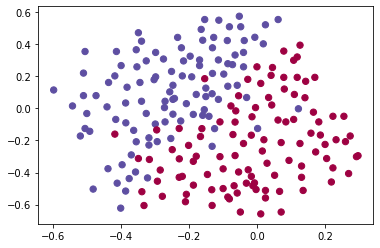

In [22]:
X_train, y_train, X_test, y_test = load_2D_dataset()

print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

### Without Regularization

Large NN architecture to make it overfit

In [0]:
random_state = 42
epochs = 50000
learning_rate = 0.3
l2_lambda = 0

model = make_model(X_train, y_train, random_state)

In [24]:
history = []
for i in range(epochs):
  model = forward_prop(X_train, model)
  loss = calculate_loss(y_train, model, l2_lambda)
  history.append(loss)
  model = backward_prop(X_train, y_train, model)
  model = update_weights(model, X_train, l2_lambda, learning_rate)

  if i%(epochs/10)==0:
    print('Epoch: {}\tLoss: {:.6f}\tTrain Accuracy: {:.3f}\tTest Accuracy: {:.3f}'.format(i, loss, accuracy_score(y_train, predict(X_train, y_train, model)), accuracy_score(y_test, predict(X_test, y_test, model))))

Epoch: 0	Loss: 0.907996	Train Accuracy: 0.498	Test Accuracy: 0.545
Epoch: 5000	Loss: 0.194347	Train Accuracy: 0.934	Test Accuracy: 0.930
Epoch: 10000	Loss: 0.186920	Train Accuracy: 0.924	Test Accuracy: 0.930
Epoch: 15000	Loss: 0.177601	Train Accuracy: 0.934	Test Accuracy: 0.930
Epoch: 20000	Loss: 0.167569	Train Accuracy: 0.934	Test Accuracy: 0.940
Epoch: 25000	Loss: 0.164721	Train Accuracy: 0.929	Test Accuracy: 0.935
Epoch: 30000	Loss: 0.153289	Train Accuracy: 0.943	Test Accuracy: 0.950
Epoch: 35000	Loss: 0.150506	Train Accuracy: 0.943	Test Accuracy: 0.950
Epoch: 40000	Loss: 0.151550	Train Accuracy: 0.943	Test Accuracy: 0.950
Epoch: 45000	Loss: 0.147485	Train Accuracy: 0.924	Test Accuracy: 0.940


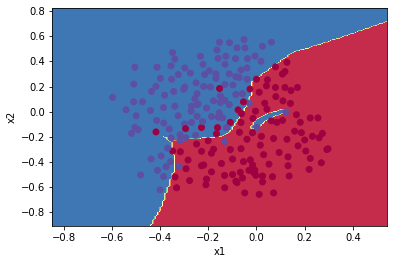

In [25]:
plot_decision_boundary(model, X_train, y_train)

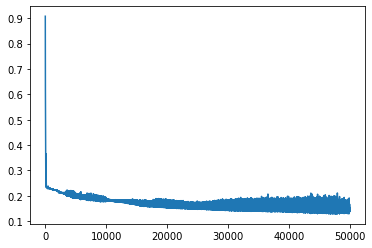

In [26]:
plt.plot(history)

### With Regularization

Same architecture and same number of epochs for comparison

In [0]:
l2_lambda = 0.7

model = make_model(X_train, y_train, random_state)

In [28]:
history = []
for i in range(epochs):
  model = forward_prop(X_train, model)
  loss = calculate_loss(y_train, model, l2_lambda)
  history.append(loss)
  model = backward_prop(X_train, y_train, model)
  model = update_weights(model, X_train, l2_lambda, learning_rate)

  if i%(epochs/10)==0:
    print('Epoch: {}\tLoss: {:.6f}\tTrain Accuracy: {:.3f}\tTest Accuracy: {:.3f}'.format(i, loss, accuracy_score(y_train, predict(X_train, y_train, model)), accuracy_score(y_test, predict(X_test, y_test, model))))

Epoch: 0	Loss: 0.954393	Train Accuracy: 0.498	Test Accuracy: 0.545
Epoch: 5000	Loss: 0.270515	Train Accuracy: 0.924	Test Accuracy: 0.930
Epoch: 10000	Loss: 0.270044	Train Accuracy: 0.924	Test Accuracy: 0.930
Epoch: 15000	Loss: 0.269819	Train Accuracy: 0.924	Test Accuracy: 0.930
Epoch: 20000	Loss: 0.269725	Train Accuracy: 0.924	Test Accuracy: 0.930
Epoch: 25000	Loss: 0.269674	Train Accuracy: 0.924	Test Accuracy: 0.930
Epoch: 30000	Loss: 0.269644	Train Accuracy: 0.924	Test Accuracy: 0.930
Epoch: 35000	Loss: 0.269619	Train Accuracy: 0.924	Test Accuracy: 0.930
Epoch: 40000	Loss: 0.269613	Train Accuracy: 0.924	Test Accuracy: 0.930
Epoch: 45000	Loss: 0.269597	Train Accuracy: 0.924	Test Accuracy: 0.930


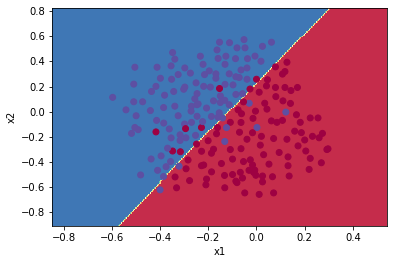

In [29]:
plot_decision_boundary(model, X_train, y_train)

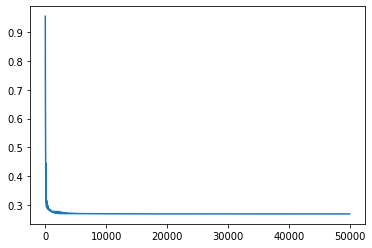

In [30]:
plt.plot(history)